In [1]:
""" github 연동 """
!git clone https://github.com/ku-sungsukim/2025-LGElec-Day4.git ### colab 사용시

Cloning into '2025-LGElec-Day4'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 38 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 6.25 MiB | 11.45 MiB/s, done.
Resolving deltas: 100% (4/4), done.


## **0. 필요 패키지 불러오기**

In [2]:
""" 데이터 전처리 관련 패키지 """
import pandas as pd
import numpy as np


""" 기계학습 모델 구축 및 평가 패키지 """
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).reshape(-1), np.array(y_pred).reshape(-1)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


""" 데이터 시각화 패키지 """
import matplotlib.pyplot as plt
%matplotlib inline


""" 경고 숨기기 """
import warnings
warnings.filterwarnings(action='ignore')

## **1. 데이터 불러오기 및 전처리**
 - 분석데이터: Google Keyword Trend (2012년부터 2022년까지 10년간 월단위 '데이터분석' 키워드 관심도 변화량)

 - https://trends.google.com/trends/explore?date=2012-01-01%202022-01-01&geo=KR&q=%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D

#### **1-1. 데이터 개요 파악 및 전처리**

In [3]:
""" 데이터 불러오기 """

"""
데이터 개요
 - 관측치 개수: 121개
 - 변수 개수: 1개

주요 변수 정보
 - 카테고리: 모든 카테고리: 월별 '데이터분석'키워드 검색횟수
"""

"""
Q1. 데이터를 불러오기
 - 로컬경로: data/googletrend_keyword.csv
 - colab경로: /content/2025-LGElec-Day4/data/googletrend_keyword.csv
"""

# data = pd.read_csv('data/googletrend_keyword.csv') ### 로컬 사용시
data = pd.read_csv('/content/2025-LGElec-Day4/data/googletrend_keyword.csv') ### colab 사용시

data

,카테고리: 모든 카테고리
월,데이터분석: (대한민국)
2012-01,3
2012-02,15
2012-03,9
2012-04,0
...,...
2021-09,93
2021-10,78
2021-11,69
2021-12,71


In [4]:
""" 간단한 전처리 (1) """

"""
Q1. 불필요한 1행 제거
"""

data = data.rename(columns={'카테고리: 모든 카테고리': 'data_analysis(korea)'}) ### 변수명 변경
data = data[1:] ### 불필요한 행 제거
data

,data_analysis(korea)
2012-01,3
2012-02,15
2012-03,9
2012-04,0
2012-05,8
...,...
2021-09,93
2021-10,78
2021-11,69
2021-12,71


In [5]:
""" 간단한 전처리 (2) """

"""
Q1. 데이터의 index 데이터 타입을 datatime으로 변환
"""

data = data.astype(np.int64(data['data_analysis(korea)'])) ### 변수타입 변환
data.index = pd.to_datetime(data.index) ### index 타입 변환
data

,data_analysis(korea)
2012-01-01,3
2012-02-01,15
2012-03-01,9
2012-04-01,0
2012-05-01,8
...,...
2021-09-01,93
2021-10-01,78
2021-11-01,69
2021-12-01,71


#### **1-2. 탐색적 데이터 분석**

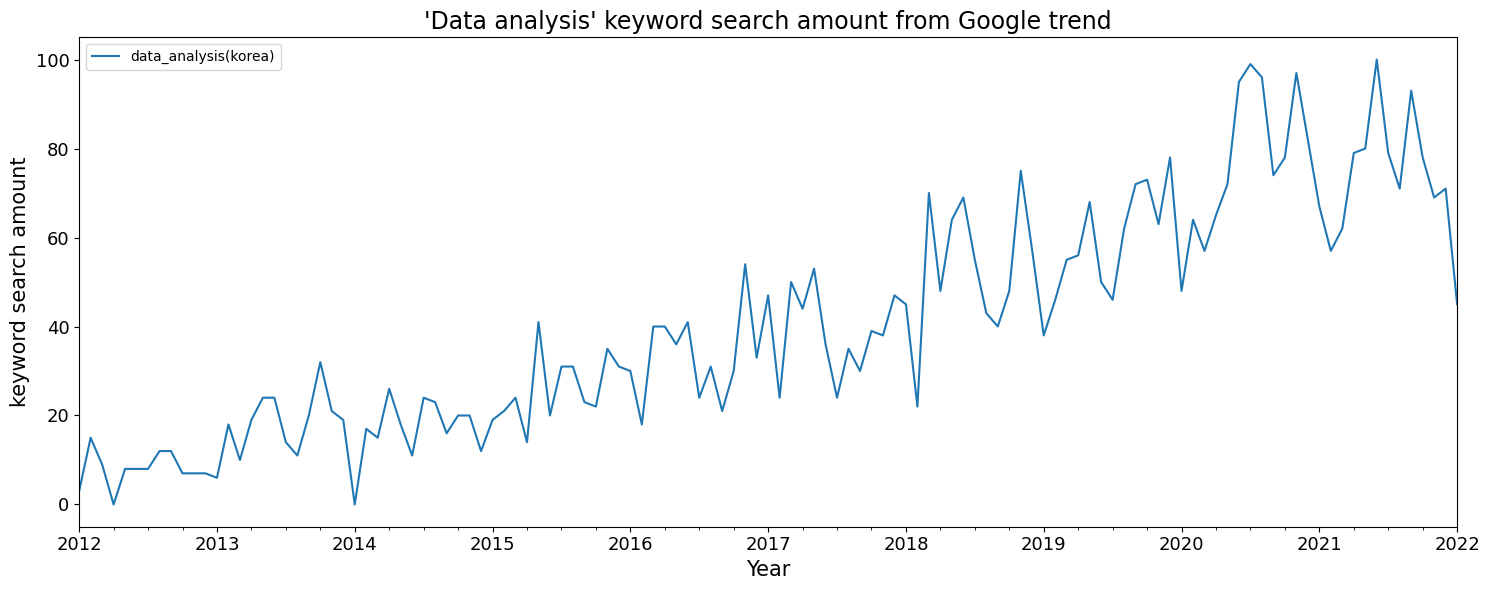

In [6]:
""" 탐색적 데이터 분석: 데이터 시각화를 통해 시계열 형태 확인 """

"""
Q1. 변수 data_analysis(korea)의 시간에 따른 추세 시각화
 - Figure 크기: (15, 6)
 - x축 및 y축 눈금의 폰트크기 모두 13으로 지정
 - Figure 제목은 'Data analysis' keyword search amount from Google trend, 폰트크기는 17로 지정
 - x축 및 y축 레이블의 폰트크기는 모두 15로 지정하며, 레이블 이름은 각각 Year와 keyword search amount로 지정
"""

data.plot(figsize=(15, 6))

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.title("'Data analysis' keyword search amount from Google trend", fontsize=17)
plt.xlabel('Year', fontsize=15)
plt.ylabel('keyword search amount', fontsize=15)
plt.tight_layout()
plt.show()

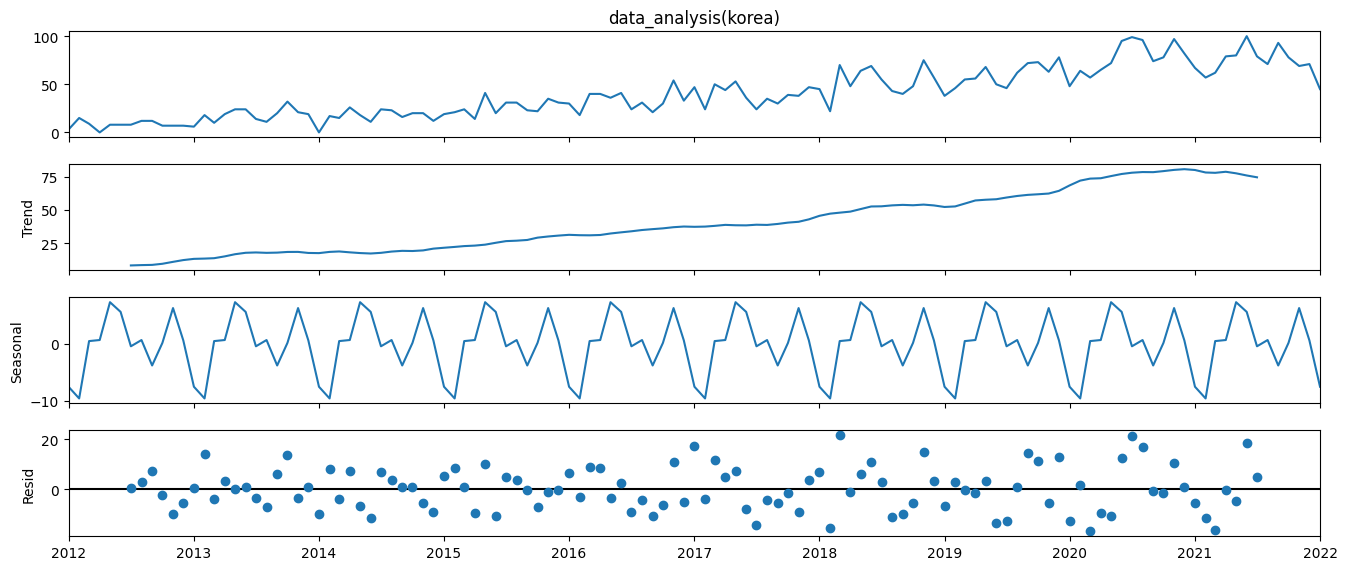

In [7]:
""" 탐색적 데이터 분석: 시계열 분해 """

"""
Q1. 시계열 데이터를 [추세(Trend)변동 + 계절(Seasonal)변동 + 우연(Random)변동]으로 분해할 것
"""

decompostion = sm.tsa.seasonal_decompose(data['data_analysis(korea)'],  model='additive')

fig = decompostion.plot()
fig.set_size_inches(15, 6)
plt.show()

#### **1-3. 학습/평가 데이터 분할**

In [8]:
""" 학습/평가데이터 분할 """

"""
Q1. 학습데이터와 평가데이터 분할
 - 학습: ~ 2019년 12월
 - 평가: 2020년 1월 ~
"""

train = data[:'2019-12']
test  = data['2020-01':]

train.shape, test.shape

((96, 1), (25, 1))

## **2. 모델링**

#### **2-1. 구간평균법**

In [9]:
""" 구간평균법 모델링 Version 1 """

"""
Q1: N=7로 구간평균법을 모델링하시오
 - numpy를 활용하여 직접 구간평균법 Table을 만들기
 - 기존의 결측행도 모두 표시할 것
 - 기존 값과 구간평균법 값을 함께 표현
"""

MA_N = 7
MA_train_flatten = train.values.flatten()
MA_train_pred = np.convolve(MA_train_flatten, np.ones(MA_N) / MA_N, 'valid') ### 구간평균법 연산

MA_before_value = np.empty((MA_N-1))
MA_before_value[:] = np.nan ### 빈 배열을 np.nan으로 채우기
MA_train_pred = np.concatenate((MA_before_value, MA_train_pred), axis=0) ### 구간평균법으로 구성 불가능한 부분 & 구간평균법으로 구성한 부분 병합

MA_train_df = pd.DataFrame(MA_train_pred, index=train.index, columns=[f'MA_{MA_N}'])
MA_train_df = pd.concat([train, MA_train_df], axis=1)
MA_train_df

,data_analysis(korea),MA_7
2012-01-01,3,NaN
2012-02-01,15,NaN
2012-03-01,9,NaN
2012-04-01,0,NaN
2012-05-01,8,NaN
...,...,...
2019-08-01,62,54.714286
2019-09-01,72,58.428571
2019-10-01,73,61.000000
2019-11-01,63,62.000000


In [10]:
""" 구간평균법 예측 """

"""
Q1. 학습데이터에 적합된 구간평균법 모델로 Test 기간을 예측
 - 최종적으로는 기존 label과 예측값을 함께 표현
"""

MA_pred = [MA_train_pred[-1]] * len(test) ### 예측값 산출
MA_test_df = pd.DataFrame(MA_pred, index=test.index, columns=[f'MA_{MA_N}'])
MA_test_df = pd.concat([test, MA_test_df], axis=1)
MA_test_df

,data_analysis(korea),MA_7
2020-01-01,48,63.428571
2020-02-01,64,63.428571
2020-03-01,57,63.428571
2020-04-01,65,63.428571
2020-05-01,72,63.428571
2020-06-01,95,63.428571
2020-07-01,99,63.428571
2020-08-01,96,63.428571
2020-09-01,74,63.428571
2020-10-01,78,63.428571


In [11]:
""" 구간평균법 평가 """

"""
Q1. 구간평균법의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, MA_test_df[f"MA_{MA_N}"]), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, MA_test_df[f"MA_{MA_N}"])), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, MA_test_df[f"MA_{MA_N}"]), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, MA_test_df[f"MA_{MA_N}"]), 2)}')
print(f'R2 score: {np.round(r2_score(test, MA_test_df[f"MA_{MA_N}"]), 2)}')

MSE: 368.0
RMSE: 19.18
MAE: 15.54
MAPE: 19.54
R2 score: -0.59


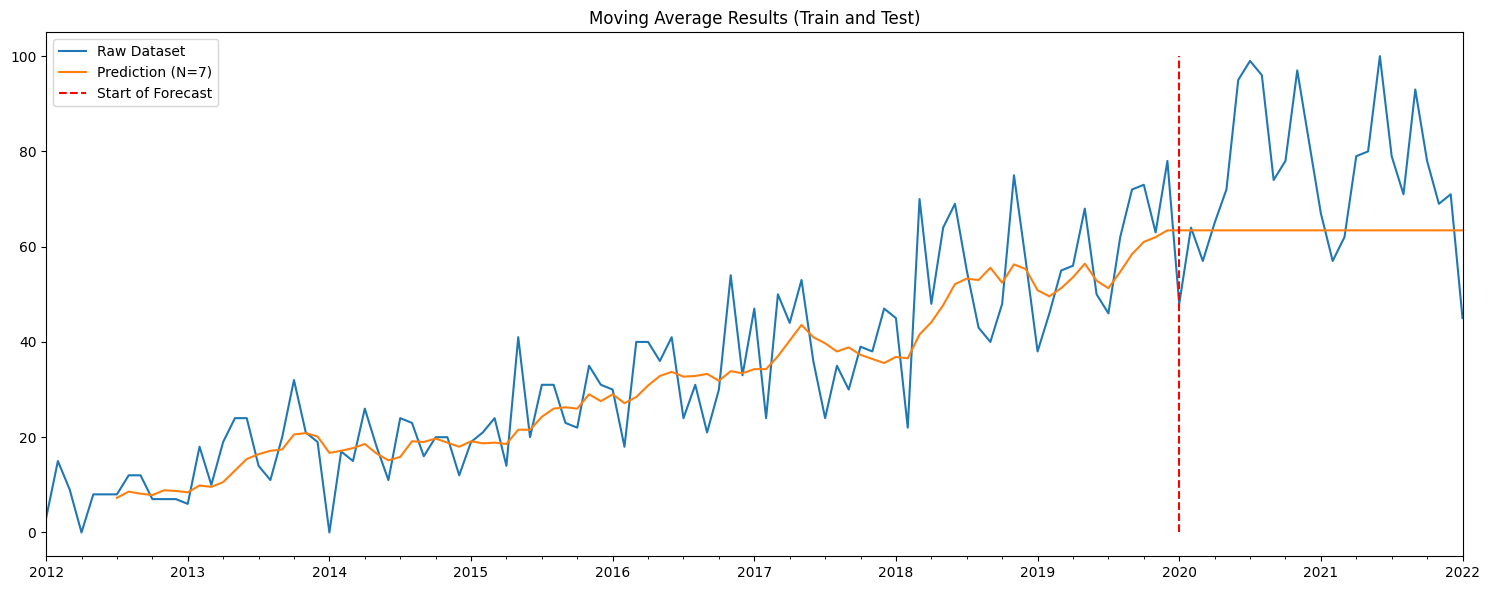

In [12]:
""" 구간평균법 시각화 """

"""
Q1. 기존 값과 구간평균법의 예측값을 함께 시각화
 - 기존값 및 예측값의 레이블: Raw Dataset, MA (N=7)
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것
   * 수직선 y범위: 0~100 / train 및 test 분기점: 2020-01-01
 - 실제값 / 예측값 / train 및 test 분기점에 대해 범례를 설정할 것 (위치: 좌상단) /// 레이블: Raw Dataset / Prediction (N=7) / Start of Forecast
 - Figure 제목: Moving Average Results (Train and Test)
"""

""" train 예측값과 test 예측값 종합 """
MA_total_visualization_df = pd.concat([MA_train_df, MA_test_df], axis=0)

""" 시각화 """
fig, ax = plt.subplots(figsize=(15, 6))
MA_total_visualization_df.plot(ax=ax)

ax.vlines(test.index[0], ymin=0, ymax=100, linestyle='--', color='r')
ax.legend(['Raw Dataset', f'Prediction (N={MA_N})', 'Start of Forecast'], loc='upper left')
plt.title('Moving Average Results (Train and Test)')
plt.tight_layout()
plt.show()

In [13]:
""" 구간평균법 모델링 (Simple Version) """

"""
Q1: N=7로 구간평균법을 모델링하시오
 - pandas의 rolling함수를 활용
 - 기존의 결측행도 모두 표시할 것
"""

MA_N = 7

MA_train_df2 = train.rolling(MA_N).mean()
MA_train_df2.columns = [f'MA_{MA_N}']
MA_train_df2

,MA_7
2012-01-01,NaN
2012-02-01,NaN
2012-03-01,NaN
2012-04-01,NaN
2012-05-01,NaN
...,...
2019-08-01,54.714286
2019-09-01,58.428571
2019-10-01,61.000000
2019-11-01,62.000000


#### **2-2. 단순지수평활법 (Simple Exponential Smoothing)**

In [14]:
""" 학습데이터로 단순지수평활법 모델링 """

"""
Q1. 학습데이터로 단순지수평활법을 모델링 및 적합
 - 직접 numpy와 pandas를 활용하여 표를 만들며 단순지수평활법 구현
 - Observation, Level, Forecast 값을 모두 보여줄 것
 - alpha: 0.8
"""

""" Step1. 초기 Table 생성 """
SES_initial_df = pd.DataFrame([np.nan], index=[0], columns=['data_analysis(korea)'])
SES_train_df = pd.concat([SES_initial_df, train], axis=0)

SES_train_df['Level'] = np.nan
SES_train_df['Forecast'] = np.nan

SES_L_0 = np.mean(train) ### 초기 L_0값 연산
SES_train_df.loc[0, 'Level'] = SES_L_0

""" Step2. 학습데이터로 단순지수평활법 적합"""
SES_alpha = 0.8

for i in range(len(SES_train_df)):

    if i == 0:
        continue

    SES_current_time = SES_train_df.index[i]
    SES_previous_time = SES_train_df.index[i-1]

    SES_x = SES_train_df.loc[SES_current_time, 'data_analysis(korea)'] ### 현재시점 observation
    SES_L_prev = SES_train_df.loc[SES_previous_time, 'Level'] ### 이전시점 level
    SES_train_df.loc[SES_current_time, 'Level'] = (SES_alpha)*SES_x + (1-SES_alpha)*SES_L_prev ### 단순지수평활법 연산

SES_train_df

,data_analysis(korea),Level,Forecast
0,NaN,31.625000,NaN
2012-01-01 00:00:00,3.0,8.725000,NaN
2012-02-01 00:00:00,15.0,13.745000,NaN
2012-03-01 00:00:00,9.0,9.949000,NaN
2012-04-01 00:00:00,0.0,1.989800,NaN
...,...,...,...
2019-08-01 00:00:00,62.0,59.083857,NaN
2019-09-01 00:00:00,72.0,69.416771,NaN
2019-10-01 00:00:00,73.0,72.283354,NaN
2019-11-01 00:00:00,63.0,64.856671,NaN


In [15]:
""" 단순지수평활법 Test기간 예측 """

"""
Q1. 단순지수평활법으로 Test 기간 예측
"""

SES_L_pred = SES_train_df.iloc[-1]['Level']
SES_test_pred = [SES_L_pred] * len(test) ### 단순지수평활법 예측값 산출

SES_test_df = pd.DataFrame(data=SES_test_pred,
                             index=test.index,
                             columns=[f'SES_{SES_alpha}'])

SES_test_df

,SES_0.8
2020-01-01,75.371334
2020-02-01,75.371334
2020-03-01,75.371334
2020-04-01,75.371334
2020-05-01,75.371334
2020-06-01,75.371334
2020-07-01,75.371334
2020-08-01,75.371334
2020-09-01,75.371334
2020-10-01,75.371334


In [16]:
""" 단순지수평활법 평가 """

"""
Q1. 단순지수평활법의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, SES_test_df[f"SES_{SES_alpha}"]), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, SES_test_df[f"SES_{SES_alpha}"])), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, SES_test_df[f"SES_{SES_alpha}"]), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, SES_test_df[f"SES_{SES_alpha}"]), 2)}')
print(f'R2 score: {np.round(r2_score(test, SES_test_df[f"SES_{SES_alpha}"]), 2)}')

MSE: 231.37
RMSE: 15.21
MAE: 12.37
MAPE: 17.86
R2 score: -0.0


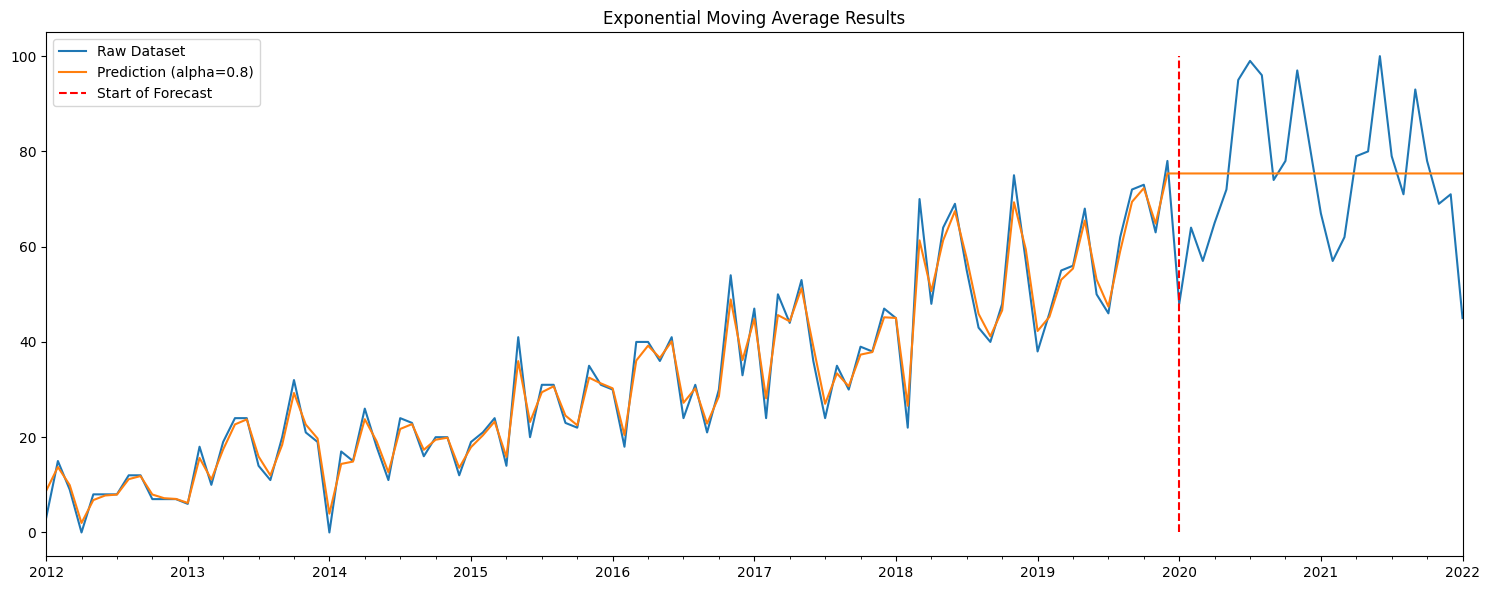

In [17]:
""" 단순지수평활법 시각화 """

"""
Q1. 기존 값과 단순지수평활법의 예측값을 함께 시각화
  - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것
   * 수직선 y범위: 0~100 / train 및 test 분기점: 2020-01-01
 - 실제값, 예측값, train/test가 나뉘는 시점에 대해 범례를 설정할 것 (위치: 좌상단) / 레이블: Raw Dataset / Prediction (alpha=0.8) / Start of Forecast
 - Figure 제목: Exponential Moving Average Results
"""

""" train 예측값과 test 예측값 종합 """
SES_train_visualization_df = SES_train_df[['Level']]
SES_train_visualization_df = SES_train_visualization_df.rename(columns={'Level':f'SES_{SES_alpha}'})

SES_test_visualization_df = SES_test_df.copy()
SES_total_visualization_df = pd.concat([SES_train_visualization_df, SES_test_visualization_df], axis=0).iloc[1:]
SES_total_visualization_df.index = pd.to_datetime(SES_total_visualization_df.index)

""" 시각화 """
fig, ax = plt.subplots(figsize=(15, 6))
data.plot(ax=ax) ### 기존 전체 데이터 시각화
SES_total_visualization_df.plot(ax=ax) ### 단순지수평활법 예측값 시각화

ax.vlines(test.index[0], ymin=0, ymax=100, linestyle='--', color='r') ### train/test 분리 시점 시각화
ax.legend(['Raw Dataset', f'Prediction (alpha={SES_alpha})', 'Start of Forecast'], loc='upper left')
plt.title('Exponential Moving Average Results')
plt.tight_layout()
plt.show()

In [18]:
""" 학습데이터로 단순지수평활법 모델링 (Simple Version) """

"""
Q1. pandas의 ewm함수를 활용하여 구현
 - 정규화는 수행하지 않음
"""

initial_df = pd.DataFrame([SES_L_0], index=[0], columns=['data_analysis(korea)'])
SES_train_df2 = pd.concat([initial_df, train], axis=0)
SES_train_df2 = SES_train_df2.ewm(alpha=SES_alpha, adjust=False).mean() ### 단순지수평활법 모델링
SES_train_df2

,data_analysis(korea)
0,31.625000
2012-01-01 00:00:00,8.725000
2012-02-01 00:00:00,13.745000
2012-03-01 00:00:00,9.949000
2012-04-01 00:00:00,1.989800
...,...
2019-08-01 00:00:00,59.083857
2019-09-01 00:00:00,69.416771
2019-10-01 00:00:00,72.283354
2019-11-01 00:00:00,64.856671


#### **2-3. 이중지수평활법**

In [19]:
""" 이중지수평활법의 초기값 산출 """

"""
Q1. 이중지수평활법의 Level과 Trend의 초기값을 산출
 - statsmodels 패키지를 활용
"""

DES_reg = train.reset_index()
DES_reg_x = pd.DataFrame(DES_reg.index+1, columns=['time'])
DES_reg_y = DES_reg['data_analysis(korea)']

DES_reg_x = sm.add_constant(DES_reg_x) ### 회귀적합을 위한 상수항 추가
DES_reg_model = sm.OLS(DES_reg_y, DES_reg_x) ### 회귀모형 정의
DES_results = DES_reg_model.fit() ### 회귀모형 파라미터 산출

DES_L_0, DES_B_0 = DES_results.params
print(f'Level의 초기값(β0): {DES_L_0} // Trend의 초기값(β1): {DES_B_0} \n')

Level의 초기값(β0): 2.376315789473672 // Trend의 초기값(β1): 0.6030656538252848 



In [20]:
""" 학습데이터로 단순지수평활법 모델링 """

"""
Q1. 학습데이터로 단순지수평활법을 모델링 및 적합
 - 직접 numpy와 pandas를 활용하여 표를 만들며 이중지수평활법 구현
 - Observation, Level, Trend, Forecast 값을 모두 보여줄 것
 - alpha: 0.2 / DES_beta: 0.15
"""

""" Step1. 초기 Table 생성"""
DES_initial_df = pd.DataFrame(np.zeros(1), index=[0], columns=['data_analysis(korea)'])
DES_train_df = pd.concat([DES_initial_df, train], axis=0)

DES_train_df['Level'] = np.nan
DES_train_df['Trend'] = np.nan
DES_train_df['Forecast'] = np.nan

DES_train_df.loc[0, 'Level'] = DES_L_0
DES_train_df.loc[0, 'Trend'] = DES_B_0


""" Step2. 학습데이터로 이중지수평활법 모델링"""
DES_alpha = 0.2
DES_beta = 0.15

for i in range(len(DES_train_df)):

    if i == 0:
        continue

    DES_current_time = DES_train_df.index[i]
    DES_previous_time = DES_train_df.index[i-1]

    DES_x = DES_train_df.loc[DES_current_time, 'data_analysis(korea)']  ### 현재 Observation
    DES_L_prev = DES_train_df.loc[DES_previous_time, 'Level'] ### 이전 Level
    DES_T_prev = DES_train_df.loc[DES_previous_time, 'Trend'] ### 이전 Trend

    DES_train_df.loc[DES_current_time, 'Level'] = DES_alpha*DES_x + (1-DES_alpha)*(DES_L_prev+DES_T_prev) ### Level에 이중지수평활법 적용
    DES_train_df.loc[DES_current_time, 'Trend'] = DES_beta*(DES_train_df.loc[DES_current_time, 'Level']-DES_L_prev) + (1-DES_beta)*(DES_T_prev) ### Trend에 이중지수평활법 적용

DES_train_df


,data_analysis(korea),Level,Trend,Forecast
0,0.0,2.376316,0.603066,NaN
2012-01-01 00:00:00,3.0,2.983505,0.603684,NaN
2012-02-01 00:00:00,15.0,5.869751,0.946069,NaN
2012-03-01 00:00:00,9.0,7.252656,1.011594,NaN
2012-04-01 00:00:00,0.0,6.611400,0.763666,NaN
...,...,...,...,...
2019-08-01 00:00:00,62.0,56.730314,0.336902,NaN
2019-09-01 00:00:00,72.0,60.053773,0.784886,NaN
2019-10-01 00:00:00,73.0,63.270927,1.149726,NaN
2019-11-01 00:00:00,63.0,64.136523,1.107106,NaN


In [21]:
""" 이중지수평활법 Test기간 예측 """

"""
Q1. 이중지수평활법으로 Test 기간 예측
"""

DES_L_Pred = DES_train_df.iloc[-1]['Level']
DES_T_Pred = DES_train_df.iloc[-1]['Trend']
DES_test_pred = [DES_L_Pred + i*DES_T_Pred for i in range(len(test))] ### 예측값 산출

DES_test_df = pd.DataFrame(data=DES_test_pred,
                             index=test.index,
                             columns=['DES'])
DES_test_df

,DES
2020-01-01,67.794903
2020-02-01,69.284701
2020-03-01,70.774499
2020-04-01,72.264296
2020-05-01,73.754094
2020-06-01,75.243891
2020-07-01,76.733689
2020-08-01,78.223487
2020-09-01,79.713284
2020-10-01,81.203082


In [22]:
""" 이중지수평활법 평가 """

"""
Q1. 이중지수평활법의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, DES_test_df["DES"]), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, DES_test_df["DES"])), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, DES_test_df["DES"]), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, DES_test_df["DES"]), 2)}')
print(f'R2 score: {np.round(r2_score(test, DES_test_df["DES"]), 2)}')

MSE: 444.96
RMSE: 21.09
MAE: 17.03
MAPE: 25.77
R2 score: -0.92


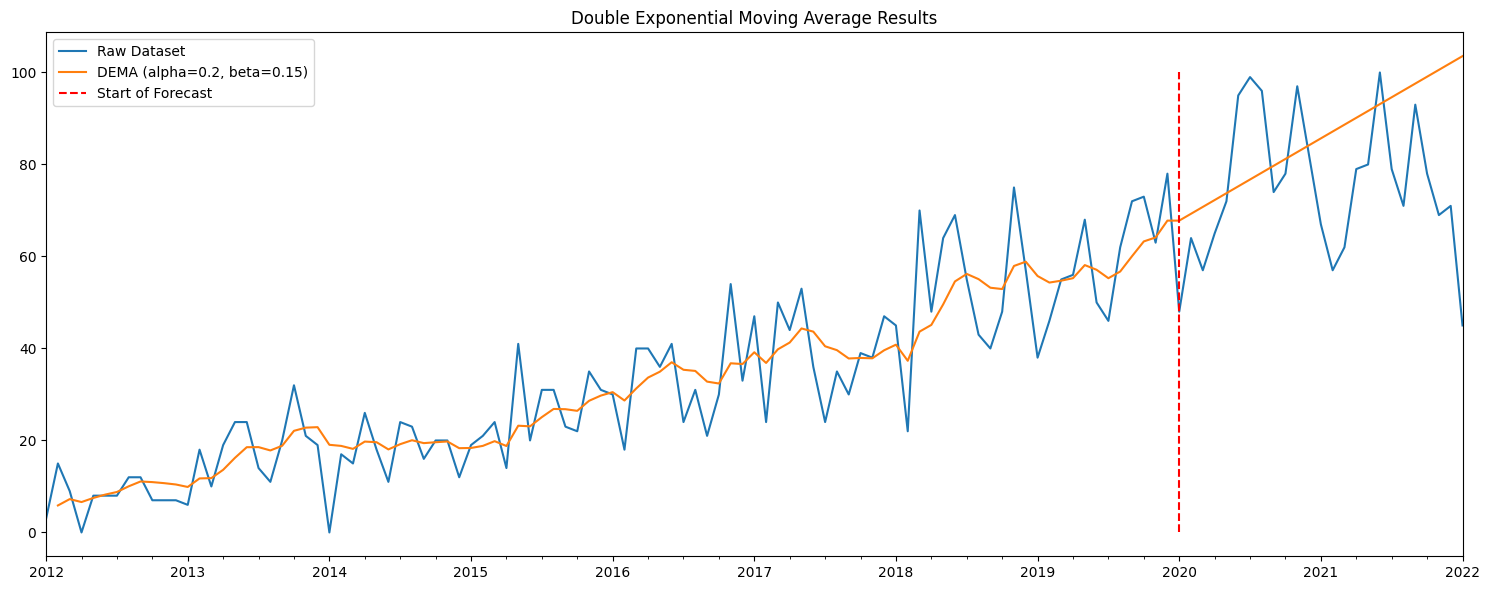

In [23]:
""" 이중지수평활법 시각화 """

"""
Q1. 기존 값과 이중지수평활법의 예측값을 함께 시각화
 - Figure 크기: (15, 6)
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것
   * 수직선 y범위: 0~100 / train 및 test 분기점: 2020-01-01
 - 실제값 / 예측값 / train 및 test 분기점에 대해 범례를 설정할 것 (위치: 좌상단) --> Raw Dataset / DEMA (alpha=0.2, beta=0.15 / Start of Forecast
 - Figure 제목: Double Exponential Moving Average Results
"""

""" train 예측값과 test 예측값 종합 """
DES_train_visualization_df = pd.DataFrame(DES_train_df.iloc[1:]['Level'])
DES_train_visualization_df.columns = ['DES']
DES_test_visualization_df = DES_test_df.copy()

DES_total_visualization_df = pd.concat([DES_train_visualization_df, DES_test_visualization_df], axis=0).iloc[1:]
DES_total_visualization_df.index = pd.to_datetime(DES_total_visualization_df.index)

""" 시각화 """
fig, ax = plt.subplots(figsize=(15, 6))
data.plot(ax=ax) ### 기존 전체 데이터 시각화
DES_total_visualization_df.plot(ax=ax, label=f'Prediction (alpha={DES_alpha}, beta={DES_beta})') ### 이중지수평활법 예측값 시각화

ax.vlines(test.index[0], ymin=0, ymax=100, linestyle='--', color='r') ### train/test 분리 시점 시각화
ax.legend(['Raw Dataset', f'DEMA (alpha={DES_alpha}, beta={DES_beta})', 'Start of Forecast'], loc='upper left')
plt.title('Double Exponential Moving Average Results')
plt.tight_layout()
plt.show()

#### **2-4. 홀트-윈터 지수평활법 (Addictive)**

In [24]:
""" Addictive 홀트-윈터 지수평활법 모델링 """

"""
Q1. 자동 최적화 방식으로 Addictive 홀트-윈터 지수평활법 모델 적합
 - ExponentialSmoothing 함수 활용
"""

HW_ADD_model = ExponentialSmoothing(train, trend='add', seasonal='add').fit(optimized=True) ### 홀트-윈터 지수평활법 모델링
HW_ADD_model.summary()

Dep. Variable:,data_analysis(korea),No. Observations:,96
Model:,ExponentialSmoothing,SSE,6876.105
Optimized:,True,AIC,442.060
Trend:,Additive,BIC,483.090
Seasonal:,Additive,AICC,450.943
Seasonal Periods:,12,Date:,"Mon, 03 Mar 2025"
Box-Cox:,False,Time:,06:53:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0657456,alpha,True
smoothing_trend,0.0657455,beta,True


In [25]:
""" Addictive 홀트-윈터 지수평활법 Train 및 Test 기간 예측 """

"""
Q1. Addictive 홀트-윈터 지수평활법으로 Train 및 Test 기간 예측
"""

HW_ADD_train_pred = HW_ADD_model.fittedvalues ### train 기간 적합 결과
HW_ADD_test_pred = HW_ADD_model.forecast(len(test)) ### test 기간 예측 결과

print('Additive Holt-Winter Exponential Smoothing Train Results')
print(HW_ADD_train_pred)
print('-'*30)
print('Additive Holt-Winter Smoothing Test results')
print(HW_ADD_test_pred)

Additive Holt-Winter Exponential Smoothing Train Results
2012-01-01     1.842209
2012-02-01     0.874666
2012-03-01    13.190689
2012-04-01     9.529568
2012-05-01    16.846369
                ...    
2019-08-01    55.966372
2019-09-01    54.697824
2019-10-01    60.615053
2019-11-01    66.882687
2019-12-01    63.184132
Length: 96, dtype: float64
------------------------------
Additive Holt-Winter Smoothing Test results
2020-01-01    59.621420
2020-02-01    59.041079
2020-03-01    70.830691
2020-04-01    67.865470
2020-05-01    76.270369
2020-06-01    69.920375
2020-07-01    66.065493
2020-08-01    69.080724
2020-09-01    67.591072
2020-10-01    72.471551
2020-11-01    77.972187
2020-12-01    74.592943
2021-01-01    70.056152
2021-02-01    69.475812
2021-03-01    81.265423
2021-04-01    78.300202
2021-05-01    86.705102
2021-06-01    80.355108
2021-07-01    76.500225
2021-08-01    79.515456
2021-09-01    78.025804
2021-10-01    82.906283
2021-11-01    88.406920
2021-12-01    85.027676
2

In [26]:
""" Addictive 홀트-윈터 지수평활법 평가 """

"""
Q1. Addictive 홀트-윈터 지수평활법의 성능 평가
 - MSE, RMSE, MAE, MAPE, R2score를 모두 산출할 것
"""

print(f'MSE: {np.round(mean_squared_error(test, HW_ADD_test_pred), 2)}')
print(f'RMSE: {np.round(np.sqrt(mean_squared_error(test, HW_ADD_test_pred)), 2)}')
print(f'MAE: {np.round(mean_absolute_error(test, HW_ADD_test_pred), 2)}')
print(f'MAPE: {np.round(mean_absolute_percentage_error(test, HW_ADD_test_pred), 2)}')
print(f'R2 score: {np.round(r2_score(test, HW_ADD_test_pred), 2)}')

MSE: 257.27
RMSE: 16.04
MAE: 12.9
MAPE: 17.98
R2 score: -0.11


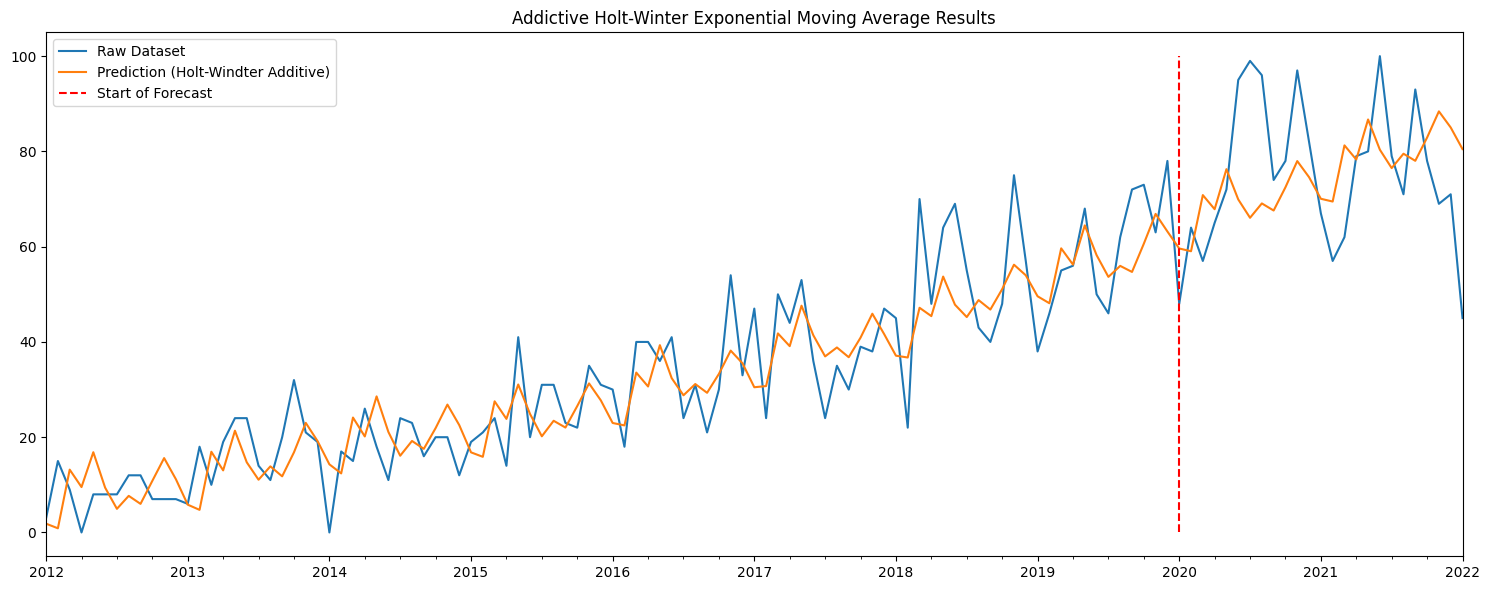

In [27]:
""" Addictive 홀트-윈터 지수평활법 시각화 """

"""
Q1. 기존 값과 Addictive 홀트-윈터 지수평활법의 예측값을 함께 시각화
 - Figure 크기: (15, 6)
 - train/test가 나뉘는 시점을 빨간 수직 점선으로 표시할 것
   * 수직선 y범위: 0~100 / train 및 test 분기점: 2020-01-01
 - 실제값 / 예측값 / train 및 test 분기점에 대해 범례를 설정할 것 (위치: 좌상단) --> Raw Dataset / Prediction (Holt-Winter Additive) / Start of Forecast
 - Figure 제목: Addictive Holt-Winter Exponential Moving Average Results
"""

""" train 예측값과 test 예측값 종합 """
HW_ADD_train_visualization_df = pd.DataFrame(HW_ADD_train_pred, columns=['HW_ADD'])
HW_ADD_test_visualization_df = pd.DataFrame(HW_ADD_test_pred, index=test.index, columns=['HW_ADD'])
HW_ADD_total_visualization_df = pd.concat([HW_ADD_train_visualization_df, HW_ADD_test_visualization_df], axis=0)

""" 시각화 """
fig, ax = plt.subplots(figsize=(15, 6))
data.plot(ax=ax) ### 기존 전체 데이터 시각화
HW_ADD_total_visualization_df.plot(ax=ax) ### Addictive 홀트-윈터 지수평활법 예측값 시각화

ax.vlines(test.index[0], ymin=0, ymax=100, linestyle='--', color='r') ### train/test 분리 시점 시각화
ax.legend(['Raw Dataset', 'Prediction (Holt-Windter Additive)', 'Start of Forecast'], loc='upper left')
plt.title('Addictive Holt-Winter Exponential Moving Average Results')
plt.tight_layout()
plt.show()

# **EOD**